In [1]:
from pathlib import Path
import sys

# Get the path of the project root
project_root = Path.cwd().parent

# Append the project root to the system path
sys.path.append(str(project_root))

In [2]:
# Import custom functions
from src.utils.utility import load_config, evaluate_model
from src.nowcast_models.autoregressive import apply_autoregression
from src.visualisation.visualise import plot_ar_results

In [3]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm
from pandas.plotting import lag_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import acf, graphics, pacf , ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor


In [4]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(14, 6))
sns.mpl.rc("font", size=14)

### Load Data


In [5]:
gdp_file_name = "gdp_clean.csv"
processed_data_path = Path.cwd().parent / "data" / "processed"
file_path = processed_data_path / gdp_file_name
gdp_df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")

gdp_df.head()

,value
date,
2000-01-01,403407
2000-04-01,406049
2000-07-01,408120
2000-10-01,409871
2001-01-01,413381


In [6]:
gdp_df.shape

(94, 1)

### Select Best Lag


In [7]:
gdp_df.index.freq = gdp_df.index.inferred_freq

In [8]:
# tmp = gdp_df.copy()
# for ilag in range(1, 5):
#     tmp.loc[:, f"lag_{ilag}"] = gdp_df["value"].shift(ilag)
#     tmp = tmp.dropna()
#     y = tmp["value"]
#     X = tmp[["lag_" + str(i) for i in range(1, ilag + 1)]]
#     X = sm.add_constant(X)

#     m1 = sm.OLS(y, X).fit()
#     m2 = AutoReg(gdp_df, ilag).fit()
#     m3 = ARIMA(gdp_df, order=(ilag, 0, 0)).fit()

#     print(f"OLS LAG:{ilag} AIC:{round(m1.bic,2)}")
#     print(f"AutoReg LAG:{ilag} AIC:{round(m2.bic,2)}")
#     print(f"ARIMA LAG:{ilag} AIC:{round(m3.bic,2)} \n")

### Autoregressive Model


In [9]:
config = load_config(
    "/Users/jacopobarone/Desktop/data_projects/nowcasting_uk_gdp/config/model_config.json"
)

train_data, pred = apply_autoregression(gdp_df, config, max_lag=5)

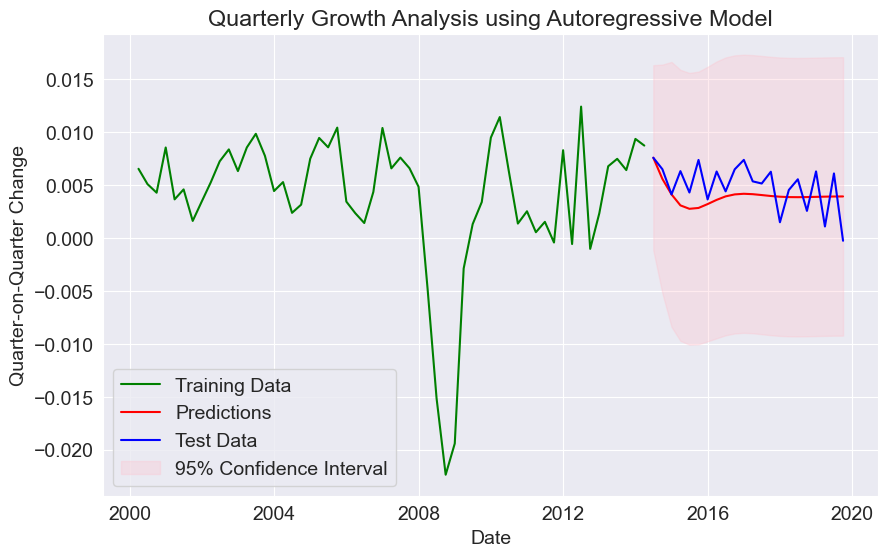

In [11]:
plot_ar_results(train_data, pred, True)

In [18]:
mse, r_squared = evaluate_model(pred["Actual"], pred["Prediction"])

print(f"MSE: {mse}\n")
print(f"R squared: {r_squared:.2f}")

MSE: 5.116040949214551e-06

R squared: -0.18


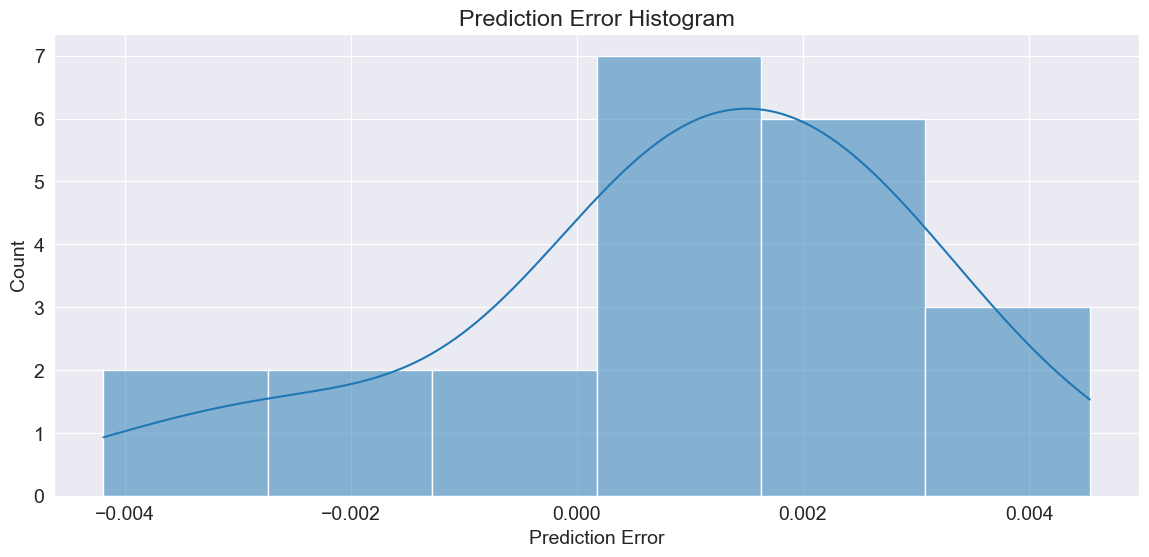

In [19]:
errors = pred['Actual'] - pred['Prediction']
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.title('Prediction Error Histogram')
plt.show()


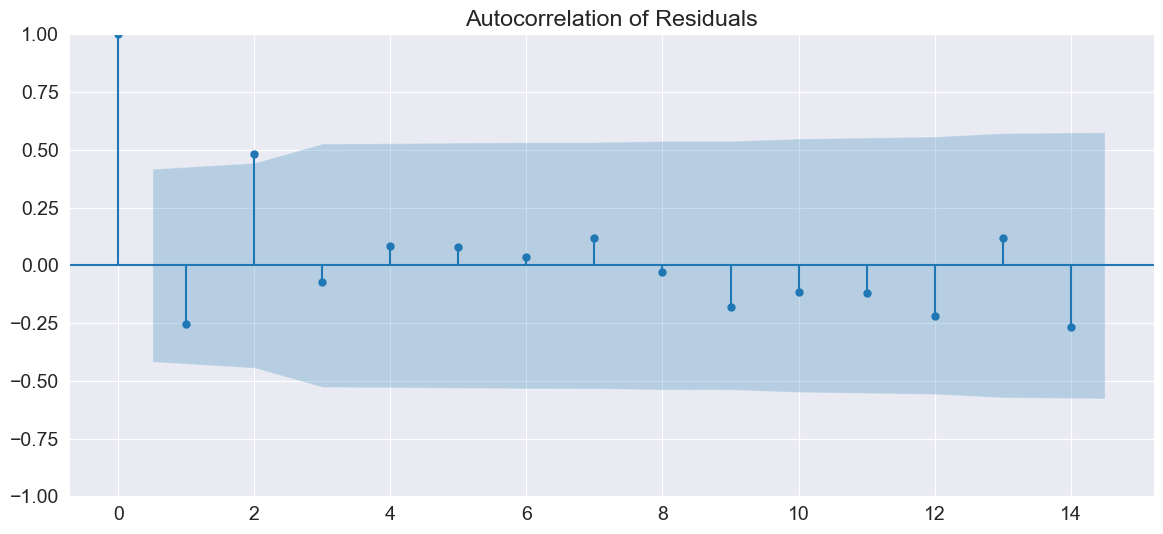

In [20]:
plot_acf(errors)
plt.title('Autocorrelation of Residuals')
plt.show()

### Autoregressive model


In [ ]:
model_params = {"start": "2005-04", "end": "2019-10", "target": "value"}
quarter_date = pd.date_range(model_params["start"], model_params["end"], freq="QS")
# Filter the date first
df = gdp_df[
    (gdp_df["date"] >= model_params["start"]) & (gdp_df["date"] <= model_params["end"])
]
df = df[["value"]].set_index(quarter_date)

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ARIMA
from sklearn.metrics import mean_squared_error

data = df.copy()

In [ ]:
from statsmodels.tsa.seasonal import STL

# Seasonal Decomposition using STL
stl = STL(data["value"], seasonal=3)
result = stl.fit()

# Plot the decomposition components
fig = result.plot()
plt.show()

In [ ]:
# Visualize the seasonal component
seasonal_component = result.seasonal
plt.plot(seasonal_component)
plt.title("Seasonal Component")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# Statistical Test for Seasonality (Augmented Dickey-Fuller Test)
adf_result = adfuller(data["value"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"{key}: {value}")

if adf_result[1] <= 0.05:
    print(
        "ADF Test Result: The data has no unit root, and it is stationary (reject the null hypothesis of non-stationarity)."
    )
else:
    print(
        "ADF Test Result: The data has a unit root and may not be stationary (fail to reject the null hypothesis of non-stationarity)."
    )

In [ ]:
import statsmodels.api as sm

# Create seasonal dummy variables (e.g., for quarters)
seasonal_dummies = (
    pd.get_dummies(data.index.quarter, prefix="quarter", drop_first=True)
    .set_index(data.index)
    .astype("float")
)

# Add the seasonal dummies to the data
data_with_dummies = pd.concat([data, seasonal_dummies], axis=1)

X = sm.add_constant(data_with_dummies[["quarter_2", "quarter_3", "quarter_4"]])
y = data_with_dummies["value"]
model = sm.OLS(y, X).fit()

# Perform an F-test to assess the significance of the seasonal dummies,
# This tests that each coefficient is jointly statistically significantly different from zero
f_test = model.f_test("quarter_2 = quarter_3 = quarter_4 = 0")

# A = np.identity(len(model.params))
# A = A[1:,:]
# print(model.f_test(A))

# Print the F-statistic and p-value
print(f"F-Statistic: {f_test.fvalue}")
print(f"p-value: {f_test.pvalue}")

In [ ]:
# Step 1: Decompose the time series to extract the seasonal component
decomposition = sm.tsa.seasonal_decompose(data["value"], model="additive")

# Extract the seasonal component
seasonal_component = decomposition.seasonal.dropna()

# Step 2: Calculate and plot the autocorrelation function (ACF)
acf = sm.graphics.tsa.plot_acf(seasonal_component, lags=10)
plt.title("ACF of Seasonal Component")
plt.show()

# Step 3: Apply spectral analysis (Fast Fourier Transform)
fft_result = np.fft.fft(seasonal_component)
n = len(seasonal_component)
frequencies = np.fft.fftfreq(n)
amplitudes = np.abs(fft_result) / n

# Plot the power spectral density
plt.figure(figsize=(10, 6))
plt.plot(frequencies[: n // 2], amplitudes[: n // 2])
plt.title("Power Spectral Density")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
import scipy.stats as stats

# Parameters for the normal distribution
mu = 0  # Mean
sigma = 0.5  # Standard deviation

# Define the range for x values (from -1 to 1)
x = np.linspace(-1, 1, 1000)

# Generate the probability density function (PDF) values for the normal distribution
pdf_values = stats.norm.pdf(x, mu, sigma)

# Plot the normal distribution
plt.plot(x, pdf_values, label="Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("Normal Distribution from -1 to 1")
plt.legend()
plt.grid(True)
plt.show()


# Generate the chi-square distribution data for the given degree of freedom
df = 5
chi_square_data = stats.chi2.rvs(df, size=10000)

# Plot the kernel density plot (PDF) for the chi-square distribution
sns.kdeplot(chi_square_data, label=f"df={df}")

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Density")
plt.title(f"Kernel Density Plot of Chi-Square Distribution with df={df}")
plt.legend()
plt.show()

In [ ]:
# Import the required packages
import scipy
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import scale

mean = 0
std = 1
num_samples = 1000
signal = np.random.normal(mean, std, size=num_samples)

plt.plot(signal)
plt.title("Gaussian White Noise")
plt.show()

# Apply the FFT on the signal
fourier = fft(signal)

# Calculate N/2 to normalize the FFT output
N = len(signal)
normalize = N / 2
frequency_axis = fftfreq(N)

# Plot the normalized FFT
sns.histplot(np.abs(fourier) / normalize)
plt.ylabel("Amplitude")
plt.xlabel("Frequency[Hz]")
plt.title("Normalized FFT Spectrum")
plt.show()

# Plot the chi-squared distribution
crit = chi2.ppf(
    q=0.95, df=2  # Find the critical value for 95% confidence*
)  # Df = number of variable categories - 1
# Generate the chi-square distribution data for the given degree of freedom
df = 2
chi_square_data = stats.chi2.rvs(df, scale=0.1, size=N)


sns.histplot(np.abs(fourier) / normalize, kde=False, stat="density", label="samples")


sns.kdeplot(chi_square_data, label=f"Chi-squared df={df}")

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Density")
# plt.title(f"Kernel Density Plot of Chi-Square Distribution with df={df}")
plt.legend()
plt.show()

In [ ]:
from scipy.signal import find_peaks
from scipy.stats import chi2

# Load your time series data into a numpy array or use your existing data
ts = data["value"].to_numpy()

# Calculate the frequencies corresponding to the periodogram
n = len(data)
frequencies = np.fft.fftfreq(n)

# Calculate the periodogram
periodogram = np.abs(np.fft.fft(ts)) / n

# Find significant peaks in the periodogram
peaks, _ = find_peaks(periodogram, height=0)  # Adjust height threshold as needed

# Set the significance level (e.g., 0.05 for a 95% confidence level)
alpha = 0.05

# Adjust the significance level for multiple comparisons (Bonferroni correction)
alpha_adjusted = alpha / len(peaks)
critical_value_adjusted = chi2.ppf(
    1 - alpha_adjusted, len(peaks)
)  # Adjusted critical value

# Calculate the test statistic
test_statistic = np.sum((periodogram[peaks] - 1) ** 2)  # Adjust for normalization

# Determine whether the detected peaks are statistically significant
significant_peaks = [
    frequencies[peak] for peak in peaks if periodogram[peak] > critical_value_adjusted
]

# Visualize the periodogram and detected peaks
plt.figure(figsize=(10, 5))
sns.lineplot(x=frequencies, y=periodogram)
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.scatter(
    frequencies[peaks], periodogram[peaks], color="red", marker="x", label="Peaks"
)
plt.axhline(
    critical_value_adjusted,
    color="green",
    linestyle="--",
    label=f"Critical Value ({alpha} significance)",
)
plt.legend()
plt.show()

# Check if seasonality is present based on the significance of the detected peaks
if len(significant_peaks) > 0:
    print("Seasonality is present.")
    print("Significant Frequencies:", significant_peaks)
else:
    print("No seasonality detected.")

In [ ]:
# Decompose the time series into its trend, seasonal, and residual components to better understand its underlying patterns
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data["value"], model="additive")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(data["value"], label="Original", color="blue")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="Trend", color="blue")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label="Seasonal", color="blue")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label="Residual", color="blue")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
seasonal_adjusted = trend + residual
sns.lineplot(data["value"], label="orginal")
sns.lineplot(seasonal_adjusted, label="SA")

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot the PACF to identify significant lags
plot_pacf(data["value"])
plt.show()

In [ ]:
# Lag Selection Using Information Criteria

# Define a range of lag orders to consider
max_lag = 5
p_values = range(1, max_lag + 1)  # Adjust the range as needed

# Initialize variables to store best model and criteria values
best_aic = float("inf")
best_order = None
best_model = None

# Iterate through different lag orders and fit ARIMA models
for p in p_values:
    order = (
        p,
        0,
        0,
    )  # Assuming no differencing and no moving average (adjust as needed)
    model = ARIMA(data["value"], order=order)

    try:
        model_fit = model.fit()
        aic = model_fit.aic

        # Check if the current model has a lower AIC
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model = model_fit
    except:
        continue

# Display the best lag order
print(f"Best Lag Order (p): {best_order}")

In [ ]:
# Define the training and validation split
train_size = int(len(data) * 0.8)
train, validation = data[:train_size], data[train_size:]

# Fit an AR model with the chosen number of lags
p = 1
model = ARIMA(train["value"], order=(p, 0, 0))
model_fit = model.fit()

# Make predictions on the validation set
forecast = model_fit.forecast(steps=len(validation))

In [ ]:
# Calculate RMSE
mse = mean_squared_error(validation["value"], forecast)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [ ]:
# Plot observed vs. predicted values
plt.plot(train.index, train["value"], label="Training Data", color="blue")
plt.plot(validation.index, validation["value"], label="Validation Data", color="green")
plt.plot(validation.index, forecast, label="AR Forecast", color="red")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("value")
plt.title("AR Model Forecast")
plt.show()

### ----


In [ ]:
# train_data = data["2005-04":"2018-10"]
# validation_data = data["2019-01":"2019-10"]

# train_data.head()

In [ ]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import chi2


def qs_test(data, seasonal_lag, k=2):
    """
    Perform the QS (Seasonality) Test on autocovariance at seasonal lags.

    This function calculates the QS (Seasonality) statistic and its associated p-value to test for seasonality in a time series at a specified seasonal lag.

    Parameters:
    - data: numpy array or pandas Series
        A time series dataset for which you want to test seasonality.

    - seasonal_lag: int
        The seasonal lag at which to check for autocovariance. For example, if analyzing monthly data, a seasonal lag of 12 would be appropriate.

    - k: int, optional (default=2)
        The number of terms in the summation of the QS statistic. A higher 'k' may capture more complex seasonality patterns.

    Returns:
    - qs_statistic: float
        The computed QS statistic, which measures the strength of seasonality in the data.

    - p_value: float
        The p-value associated with the test. A lower p-value suggests stronger evidence against the null hypothesis of no seasonality.

    Notes:
    - The QS statistic is calculated based on the autocovariances of the data at multiples of the specified seasonal lag.

    - The p-value is calculated using a chi-squared distribution with degrees of freedom equal to 'k'.

    Example:
    ```
    import numpy as np
    from your_module import qs_test

    # Load your time series data (e.g., monthly data)
    data = np.array([...])

    # Perform the QS Test with a seasonal lag of 12 (for monthly data) and k=3
    qs_statistic, p_value = qs_test(data, seasonal_lag=12, k=3)

    if p_value < 0.05:
        print("Seasonality detected.")
    else:
        print("No significant seasonality."
    ```

    References:
    - [Reference to the source or documentation of the QS test algorithm, if applicable]

    """
    n = len(data)

    # Calculate the QS statistic using the equation
    qs_statistic = 0
    for i in range(1, k + 1):
        # Calculate autocovariance at i*l
        autocovariances = sm.tsa.acovf(data, nlag=seasonal_lag * i)
        gamma_i_l = autocovariances[-1]
        # Add the contribution of the current term to the QS statistic
        qs_statistic += (max(0, gamma_i_l) ** 2) / (n - i * seasonal_lag)

    qs_statistic *= n * (n + 2)

    # Calculate the p-value using a chi-squared distribution with 'k' degrees of freedom
    p_value = 1.0 - chi2.cdf(qs_statistic, df=k)

    return qs_statistic, p_value


# Example usage:
# Assuming 'your_data' is your time series data
seasonal_lag = 4  # Example: For quarterly data with quarterly seasonality
qs_statistic, p_value = qs_test(data["value"], seasonal_lag)
print(f"QS Statistic: {qs_statistic}")
print(f"P-Value: {p_value}")

### Modelling


In [ ]:
y = gdp_df["value"]

# Split data into train and test sets
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X, y, test_size=0.2, shuffle=False
# )

In [ ]:
# Dynamic Factor Model (DFM)
dfm_model = DynamicFactor(endog=Y_train, factors=2)  # Adjust number of factors
dfm_results = dfm_model.fit()
dfm_forecast = dfm_results.forecast(steps=len(X_test))
dfm_rmse = np.sqrt(mean_squared_error(Y_test, dfm_forecast))

# Linear Regression with Regularization
regressors = [
    "Regressor1",
    "Regressor2",
    "Regressor3",
]  # Replace with actual regressor names
regressor_X_train = X_train[regressors]
regressor_X_test = X_test[regressors]

lasso = Lasso(alpha=0.1)  # Adjust alpha (regularization strength) as needed
lasso.fit(regressor_X_train, Y_train)
lasso_preds = lasso.predict(regressor_X_test)
lasso_rmse = np.sqrt(mean_squared_error(Y_test, lasso_preds))

ridge = Ridge(alpha=1.0)  # Adjust alpha as needed
ridge.fit(regressor_X_train, Y_train)
ridge_preds = ridge.predict(regressor_X_test)
ridge_rmse = np.sqrt(mean_squared_error(Y_test, ridge_preds))

enet = ElasticNet(alpha=0.1, l1_ratio=0.5)  # Adjust alpha and l1_ratio as needed
enet.fit(regressor_X_train, Y_train)
enet_preds = enet.predict(regressor_X_test)
enet_rmse = np.sqrt(mean_squared_error(Y_test, enet_preds))

In [ ]:
# Print RMSE for all models
print(f"AR Model RMSE: {ar_rmse}")
print(f"Dynamic Factor Model RMSE: {dfm_rmse}")
print(f"Lasso Regression RMSE: {lasso_rmse}")
print(f"Ridge Regression RMSE: {ridge_rmse}")
print(f"Elastic Net Regression RMSE: {enet_rmse}")